## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp018'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

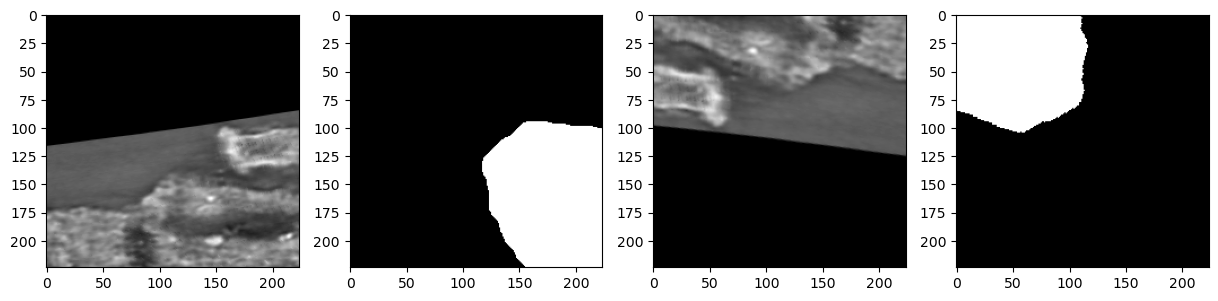

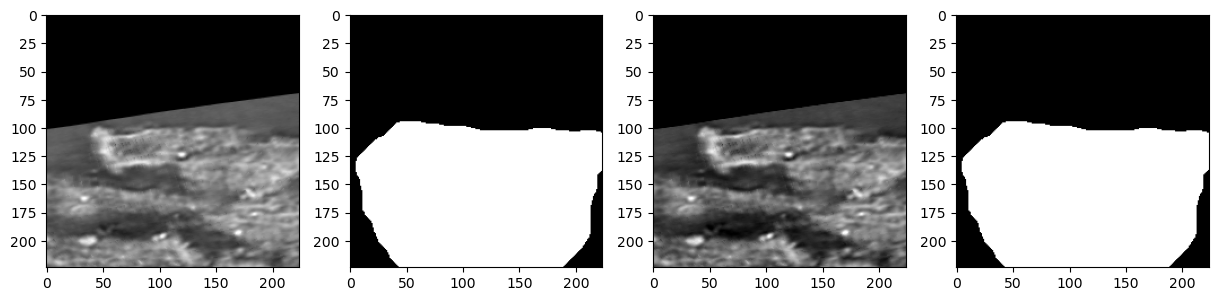

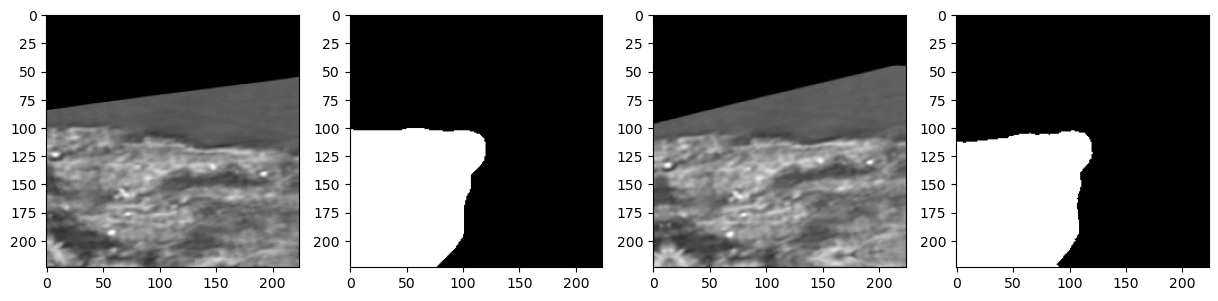

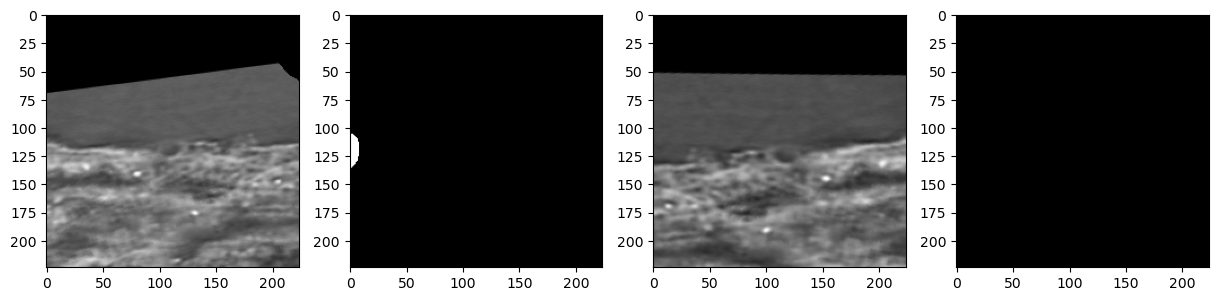

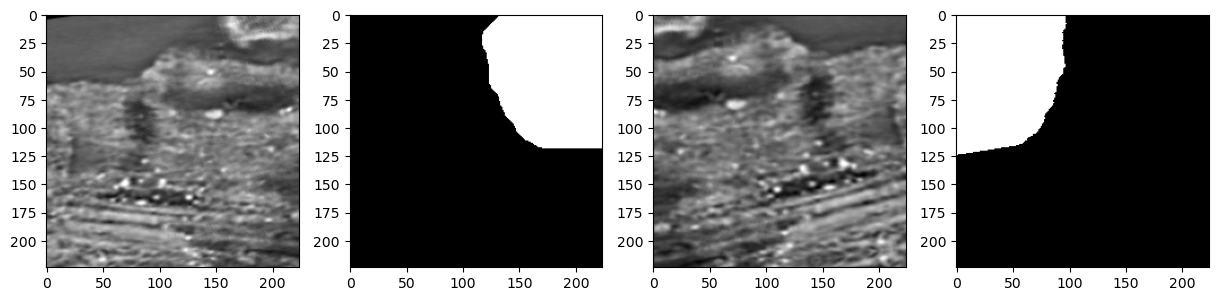

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48105

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14713964109479652
th: 0.15, fbeta: 0.1694885417609784
th: 0.2, fbeta: 0.19166799629758988
th: 0.25, fbeta: 0.2187006977748778
th: 0.3, fbeta: 0.25307038093360035
th: 0.35, fbeta: 0.29243462534001974
th: 0.4, fbeta: 0.332086361420359
th: 0.45, fbeta: 0.36934831013754127


best_th: 0.5, fbeta: 0.39845771412418135
Epoch 1 - avg_train_loss: 0.4081  avg_val_loss: 0.3095  time: 239s
Epoch 1 - avgScore: 0.3985
Epoch 1 - Save Best Score: 0.3985 Model
Epoch 1 - Save Best Loss: 0.3095 Model


th: 0.5, fbeta: 0.39845771412418135


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.17516690979878607
th: 0.15, fbeta: 0.22206904607841185
th: 0.2, fbeta: 0.27196422606709264
th: 0.25, fbeta: 0.31788953775255185
th: 0.3, fbeta: 0.3574179159454753
th: 0.35, fbeta: 0.3917111420845216
th: 0.4, fbeta: 0.41778192556517085
th: 0.45, fbeta: 0.4357270697625724


best_th: 0.5, fbeta: 0.4386689518504723
Epoch 2 - avg_train_loss: 0.3154  avg_val_loss: 0.2519  time: 241s
Epoch 2 - avgScore: 0.4387
Epoch 2 - Save Best Score: 0.4387 Model
Epoch 2 - Save Best Loss: 0.2519 Model


th: 0.5, fbeta: 0.4386689518504723


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.24906167951601568
th: 0.15, fbeta: 0.29636531564102553
th: 0.2, fbeta: 0.3404339795207255
th: 0.25, fbeta: 0.38344055763963075
th: 0.3, fbeta: 0.42283014787622325
th: 0.35, fbeta: 0.4558797277217419
th: 0.4, fbeta: 0.4793834190091848
th: 0.45, fbeta: 0.4956681892631333


best_th: 0.5, fbeta: 0.49974240121621366
Epoch 3 - avg_train_loss: 0.2774  avg_val_loss: 0.2020  time: 240s
Epoch 3 - avgScore: 0.4997
Epoch 3 - Save Best Score: 0.4997 Model
Epoch 3 - Save Best Loss: 0.2020 Model


th: 0.5, fbeta: 0.49974240121621366


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2286416722798516
th: 0.15, fbeta: 0.27486030036970616
th: 0.2, fbeta: 0.3145184093940168
th: 0.25, fbeta: 0.35147163743386123
th: 0.3, fbeta: 0.387262620636358
th: 0.35, fbeta: 0.41958933309875085
th: 0.4, fbeta: 0.4496195365433212
th: 0.45, fbeta: 0.47581564669283505


best_th: 0.5, fbeta: 0.4971060366646858
Epoch 4 - avg_train_loss: 0.2518  avg_val_loss: 0.2147  time: 241s
Epoch 4 - avgScore: 0.4971


th: 0.5, fbeta: 0.4971060366646858


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3683681385360196
th: 0.15, fbeta: 0.42335250252761053
th: 0.2, fbeta: 0.46363879876491265
th: 0.25, fbeta: 0.4960100185515024
th: 0.3, fbeta: 0.5213586975111033
th: 0.35, fbeta: 0.5401085670483187
th: 0.4, fbeta: 0.5518076858021187
th: 0.45, fbeta: 0.5591417179371707


best_th: 0.45, fbeta: 0.5591417179371707
Epoch 5 - avg_train_loss: 0.2342  avg_val_loss: 0.1860  time: 240s
Epoch 5 - avgScore: 0.5591
Epoch 5 - Save Best Score: 0.5591 Model
Epoch 5 - Save Best Loss: 0.1860 Model


th: 0.5, fbeta: 0.5581077221300534


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.296103466467237
th: 0.15, fbeta: 0.3506090514312167
th: 0.2, fbeta: 0.4022772310876543
th: 0.25, fbeta: 0.44658189113596886
th: 0.3, fbeta: 0.4831911035371383
th: 0.35, fbeta: 0.5112467969530656
th: 0.4, fbeta: 0.5345069355070037


best_th: 0.5, fbeta: 0.5664480094583056
Epoch 6 - avg_train_loss: 0.2210  avg_val_loss: 0.1894  time: 239s
Epoch 6 - avgScore: 0.5664
Epoch 6 - Save Best Score: 0.5664 Model
Epoch 6 - Save Best Loss: 0.1894 Model


th: 0.45, fbeta: 0.5543693014032978
th: 0.5, fbeta: 0.5664480094583056


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.331424738280079
th: 0.15, fbeta: 0.3883510814280789
th: 0.2, fbeta: 0.44150907526075045
th: 0.25, fbeta: 0.48451986864622154
th: 0.3, fbeta: 0.5166953068770684
th: 0.35, fbeta: 0.536256803442053
th: 0.4, fbeta: 0.5463150165977123
th: 0.45, fbeta: 0.554071622753169


best_th: 0.5, fbeta: 0.5595174889379515
Epoch 7 - avg_train_loss: 0.2092  avg_val_loss: 0.1884  time: 243s
Epoch 7 - avgScore: 0.5595


th: 0.5, fbeta: 0.5595174889379515


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3468944460729658
th: 0.15, fbeta: 0.4040780727987448
th: 0.2, fbeta: 0.4465105053755444
th: 0.25, fbeta: 0.4820809405699176
th: 0.3, fbeta: 0.5066451109817266
th: 0.35, fbeta: 0.5257677074369606
th: 0.4, fbeta: 0.5399888340286946
th: 0.45, fbeta: 0.551800162620285


best_th: 0.5, fbeta: 0.5591888681869819
Epoch 8 - avg_train_loss: 0.1964  avg_val_loss: 0.1876  time: 243s
Epoch 8 - avgScore: 0.5592


th: 0.5, fbeta: 0.5591888681869819


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2938674090289458
th: 0.15, fbeta: 0.3308463054180712
th: 0.2, fbeta: 0.3617794779457124
th: 0.25, fbeta: 0.38856355552400484
th: 0.3, fbeta: 0.41521778727652003
th: 0.35, fbeta: 0.43801210451293565
th: 0.4, fbeta: 0.456714460706199
th: 0.45, fbeta: 0.4735287597193059


best_th: 0.5, fbeta: 0.48842050048727526
Epoch 9 - avg_train_loss: 0.1804  avg_val_loss: 0.2185  time: 242s
Epoch 9 - avgScore: 0.4884


th: 0.5, fbeta: 0.48842050048727526


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2809606078665446
th: 0.15, fbeta: 0.32190485041076855
th: 0.2, fbeta: 0.35828589409746825
th: 0.25, fbeta: 0.3930385230881525
th: 0.3, fbeta: 0.4251205640222909
th: 0.35, fbeta: 0.45390162143604224
th: 0.4, fbeta: 0.4825967357871657
th: 0.45, fbeta: 0.5055807784846635


best_th: 0.5, fbeta: 0.5249985820495066
Epoch 10 - avg_train_loss: 0.1675  avg_val_loss: 0.2138  time: 242s
Epoch 10 - avgScore: 0.5250


th: 0.5, fbeta: 0.5249985820495066


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3399826515304454
th: 0.15, fbeta: 0.3813563467333396
th: 0.2, fbeta: 0.4130220098485603
th: 0.25, fbeta: 0.4388945856820995
th: 0.3, fbeta: 0.4625425090693103
th: 0.35, fbeta: 0.48202211426557845
th: 0.4, fbeta: 0.5006258386778966
th: 0.45, fbeta: 0.5185987918477494


best_th: 0.5, fbeta: 0.5278044041472897
Epoch 11 - avg_train_loss: 0.1585  avg_val_loss: 0.2227  time: 239s
Epoch 11 - avgScore: 0.5278


th: 0.5, fbeta: 0.5278044041472897


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24025807638715377
th: 0.15, fbeta: 0.26755020897989
th: 0.2, fbeta: 0.29308193711862623
th: 0.25, fbeta: 0.3182848194544654
th: 0.3, fbeta: 0.34244289008319206
th: 0.35, fbeta: 0.364221221305389
th: 0.4, fbeta: 0.38527555525255947
th: 0.45, fbeta: 0.4073607816140219


best_th: 0.5, fbeta: 0.4316173965687726
Epoch 12 - avg_train_loss: 0.1490  avg_val_loss: 0.2699  time: 241s
Epoch 12 - avgScore: 0.4316


th: 0.5, fbeta: 0.4316173965687726


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38333840248525647
th: 0.15, fbeta: 0.42208790372623434
th: 0.2, fbeta: 0.45511578990305757
th: 0.25, fbeta: 0.4804426442225066
th: 0.3, fbeta: 0.49787881464334915
th: 0.35, fbeta: 0.5128505816831861
th: 0.4, fbeta: 0.5223737401660974
th: 0.45, fbeta: 0.5286675657409494


best_th: 0.5, fbeta: 0.5303427798762343
Epoch 13 - avg_train_loss: 0.1384  avg_val_loss: 0.2259  time: 241s
Epoch 13 - avgScore: 0.5303


th: 0.5, fbeta: 0.5303427798762343


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29888975145805485
th: 0.15, fbeta: 0.34317974732797324
th: 0.2, fbeta: 0.3795359300098151
th: 0.25, fbeta: 0.4082501228423849
th: 0.3, fbeta: 0.43653724603669236
th: 0.35, fbeta: 0.4607636947212231
th: 0.4, fbeta: 0.48247589100071814
th: 0.45, fbeta: 0.5026996449329013


best_th: 0.5, fbeta: 0.521149275069249
Epoch 14 - avg_train_loss: 0.1303  avg_val_loss: 0.2174  time: 241s
Epoch 14 - avgScore: 0.5211


th: 0.5, fbeta: 0.521149275069249


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34167925188078035
th: 0.15, fbeta: 0.3811770318993216
th: 0.2, fbeta: 0.41664999161639543
th: 0.25, fbeta: 0.44625600251317565
th: 0.3, fbeta: 0.4689659313967019
th: 0.35, fbeta: 0.48880286608947215
th: 0.4, fbeta: 0.5054895032548823
th: 0.45, fbeta: 0.5173540513446695


best_th: 0.5, fbeta: 0.5262181108044064
Epoch 15 - avg_train_loss: 0.1246  avg_val_loss: 0.2242  time: 240s
Epoch 15 - avgScore: 0.5262


th: 0.5, fbeta: 0.5262181108044064


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30193323056169
th: 0.15, fbeta: 0.3317504277251393
th: 0.2, fbeta: 0.35950743004807484
th: 0.25, fbeta: 0.3835270528819607
th: 0.3, fbeta: 0.40427814892826375
th: 0.35, fbeta: 0.4241392723390494
th: 0.4, fbeta: 0.4438434651738695


best_th: 0.5, fbeta: 0.4789531020278319
Epoch 16 - avg_train_loss: 0.1162  avg_val_loss: 0.2487  time: 240s
Epoch 16 - avgScore: 0.4790


th: 0.45, fbeta: 0.4619485434190764
th: 0.5, fbeta: 0.4789531020278319


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3138068639619636
th: 0.15, fbeta: 0.3458915116837652
th: 0.2, fbeta: 0.3707064292351601
th: 0.25, fbeta: 0.39139722964068485
th: 0.3, fbeta: 0.4120119885343446
th: 0.35, fbeta: 0.43132066386860146
th: 0.4, fbeta: 0.44703092788250715
th: 0.45, fbeta: 0.4594726169690055


best_th: 0.5, fbeta: 0.4706632485766312
Epoch 17 - avg_train_loss: 0.1097  avg_val_loss: 0.2476  time: 240s
Epoch 17 - avgScore: 0.4707


th: 0.5, fbeta: 0.4706632485766312


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3783550997246989
th: 0.15, fbeta: 0.4165781143201562
th: 0.2, fbeta: 0.4431723907580217
th: 0.25, fbeta: 0.46371082115455525
th: 0.3, fbeta: 0.48220082449469287
th: 0.35, fbeta: 0.49465527724621583
th: 0.4, fbeta: 0.5056351903330161
th: 0.45, fbeta: 0.5153108151206235


best_th: 0.5, fbeta: 0.521167855124894
Epoch 18 - avg_train_loss: 0.1032  avg_val_loss: 0.2536  time: 239s
Epoch 18 - avgScore: 0.5212


th: 0.5, fbeta: 0.521167855124894


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34780080491816723
th: 0.15, fbeta: 0.37692396386505084
th: 0.2, fbeta: 0.4026497672671031
th: 0.25, fbeta: 0.42640128194323207
th: 0.3, fbeta: 0.44774590267636055
th: 0.35, fbeta: 0.4656997823009543
th: 0.4, fbeta: 0.48064800307066036
th: 0.45, fbeta: 0.49435222444574745


best_th: 0.5, fbeta: 0.5075953221412
Epoch 19 - avg_train_loss: 0.0972  avg_val_loss: 0.2681  time: 240s
Epoch 19 - avgScore: 0.5076


th: 0.5, fbeta: 0.5075953221412


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31902680046798104
th: 0.15, fbeta: 0.3477940099381537
th: 0.2, fbeta: 0.375737729453521
th: 0.25, fbeta: 0.40131200105449244
th: 0.3, fbeta: 0.42500041734444666
th: 0.35, fbeta: 0.4455712226499496
th: 0.4, fbeta: 0.4647494477244441
th: 0.45, fbeta: 0.48240338111304665


best_th: 0.5, fbeta: 0.49703911933269596
Epoch 20 - avg_train_loss: 0.0912  avg_val_loss: 0.2482  time: 239s
Epoch 20 - avgScore: 0.4970


th: 0.5, fbeta: 0.49703911933269596


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3643051537448358
th: 0.15, fbeta: 0.3948891652661903
th: 0.2, fbeta: 0.4220857491401869
th: 0.25, fbeta: 0.4469033198925457
th: 0.3, fbeta: 0.4656799150386488
th: 0.35, fbeta: 0.4799837664393411
th: 0.4, fbeta: 0.49391995065974276
th: 0.45, fbeta: 0.5060943605154459


best_th: 0.5, fbeta: 0.5167177644458145
Epoch 21 - avg_train_loss: 0.0873  avg_val_loss: 0.2761  time: 241s
Epoch 21 - avgScore: 0.5167


th: 0.5, fbeta: 0.5167177644458145


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3604440772277567
th: 0.15, fbeta: 0.39116092800602004
th: 0.2, fbeta: 0.4201762922347507
th: 0.25, fbeta: 0.444540381455703
th: 0.3, fbeta: 0.46605664076043485
th: 0.35, fbeta: 0.48174033503076025
th: 0.4, fbeta: 0.4945085515409617
th: 0.45, fbeta: 0.507059398433583


best_th: 0.5, fbeta: 0.5167313479319022
Epoch 22 - avg_train_loss: 0.0833  avg_val_loss: 0.2771  time: 240s
Epoch 22 - avgScore: 0.5167


th: 0.5, fbeta: 0.5167313479319022


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38819214982736094
th: 0.15, fbeta: 0.4201266608597724
th: 0.2, fbeta: 0.4485749222258999
th: 0.25, fbeta: 0.47040545753175356
th: 0.3, fbeta: 0.48992015114640963
th: 0.35, fbeta: 0.506995046196976
th: 0.4, fbeta: 0.5204584386348211
th: 0.45, fbeta: 0.5296375000957536


best_th: 0.5, fbeta: 0.5345901642430034
Epoch 23 - avg_train_loss: 0.0778  avg_val_loss: 0.2699  time: 240s
Epoch 23 - avgScore: 0.5346


th: 0.5, fbeta: 0.5345901642430034


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3703526373711438
th: 0.15, fbeta: 0.39904004815205585
th: 0.2, fbeta: 0.42343705486369193
th: 0.25, fbeta: 0.4462954935535011
th: 0.3, fbeta: 0.4674777038269218
th: 0.35, fbeta: 0.48386094955152353
th: 0.4, fbeta: 0.4965012014795148
th: 0.45, fbeta: 0.508467768613065


best_th: 0.5, fbeta: 0.5149609368927012
Epoch 24 - avg_train_loss: 0.0737  avg_val_loss: 0.2868  time: 240s
Epoch 24 - avgScore: 0.5150


th: 0.5, fbeta: 0.5149609368927012


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35966452844989666
th: 0.15, fbeta: 0.3905746742649959
th: 0.2, fbeta: 0.4185879879148058
th: 0.25, fbeta: 0.4430755375997919
th: 0.3, fbeta: 0.46154874679963
th: 0.35, fbeta: 0.47805050048449627
th: 0.4, fbeta: 0.49235967292382116
th: 0.45, fbeta: 0.5047735370797227


best_th: 0.5, fbeta: 0.511360792986066
Epoch 25 - avg_train_loss: 0.0736  avg_val_loss: 0.2798  time: 238s
Epoch 25 - avgScore: 0.5114


th: 0.5, fbeta: 0.511360792986066


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3614734447032592
th: 0.15, fbeta: 0.3908558166888302
th: 0.2, fbeta: 0.4191962032738887
th: 0.25, fbeta: 0.444957934190189
th: 0.3, fbeta: 0.46546710494175825
th: 0.35, fbeta: 0.4816767238175713
th: 0.4, fbeta: 0.49503141141106244
th: 0.45, fbeta: 0.5067118843343436


best_th: 0.5, fbeta: 0.5142249283505759
Epoch 26 - avg_train_loss: 0.0700  avg_val_loss: 0.2831  time: 240s
Epoch 26 - avgScore: 0.5142


th: 0.5, fbeta: 0.5142249283505759


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35809786817712164
th: 0.15, fbeta: 0.3858151716518923
th: 0.2, fbeta: 0.4103233465433493
th: 0.25, fbeta: 0.43540748777832045
th: 0.3, fbeta: 0.4561629904829935
th: 0.35, fbeta: 0.4750104583702783
th: 0.4, fbeta: 0.4924874056173406
th: 0.45, fbeta: 0.5054252332545546


best_th: 0.5, fbeta: 0.513247119204936
Epoch 27 - avg_train_loss: 0.0689  avg_val_loss: 0.2916  time: 240s
Epoch 27 - avgScore: 0.5132


th: 0.5, fbeta: 0.513247119204936


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33790761946974757
th: 0.15, fbeta: 0.3643543256493633
th: 0.2, fbeta: 0.38745879677647066
th: 0.25, fbeta: 0.4091788507659368
th: 0.3, fbeta: 0.4296764989803822
th: 0.35, fbeta: 0.4465496666307232
th: 0.4, fbeta: 0.4618375121825183
th: 0.45, fbeta: 0.47715093804780667


best_th: 0.5, fbeta: 0.49221646724965146
Epoch 28 - avg_train_loss: 0.0670  avg_val_loss: 0.2967  time: 239s
Epoch 28 - avgScore: 0.4922


th: 0.5, fbeta: 0.49221646724965146


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3533995908527644
th: 0.15, fbeta: 0.3802309099713315
th: 0.2, fbeta: 0.405920808797353
th: 0.25, fbeta: 0.42981771393941703
th: 0.3, fbeta: 0.45070430057235045
th: 0.35, fbeta: 0.4681319291100214
th: 0.4, fbeta: 0.48428604774682676
th: 0.45, fbeta: 0.49753279766149366


best_th: 0.5, fbeta: 0.5064674553806922
Epoch 29 - avg_train_loss: 0.0653  avg_val_loss: 0.2954  time: 239s
Epoch 29 - avgScore: 0.5065


th: 0.5, fbeta: 0.5064674553806922


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3503613270764733
th: 0.15, fbeta: 0.37962995533318744
th: 0.2, fbeta: 0.40527796878805983
th: 0.25, fbeta: 0.4301158205472017
th: 0.3, fbeta: 0.4498203473503502
th: 0.35, fbeta: 0.46843328501257375
th: 0.4, fbeta: 0.4853080758408444
th: 0.45, fbeta: 0.499391653246629


best_th: 0.5, fbeta: 0.5105830907146667
Epoch 30 - avg_train_loss: 0.0634  avg_val_loss: 0.2858  time: 239s
Epoch 30 - avgScore: 0.5106


th: 0.5, fbeta: 0.5105830907146667


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.296103466467237
th: 0.15, fbeta: 0.3506090514312167
th: 0.2, fbeta: 0.4022772310876543
th: 0.25, fbeta: 0.44658189113596886
th: 0.3, fbeta: 0.4831911035371383
th: 0.35, fbeta: 0.5112467969530656
th: 0.4, fbeta: 0.5345069355070037


best_th: 0.5, fbeta: 0.5664480094583056


th: 0.45, fbeta: 0.5543693014032978
th: 0.5, fbeta: 0.5664480094583056


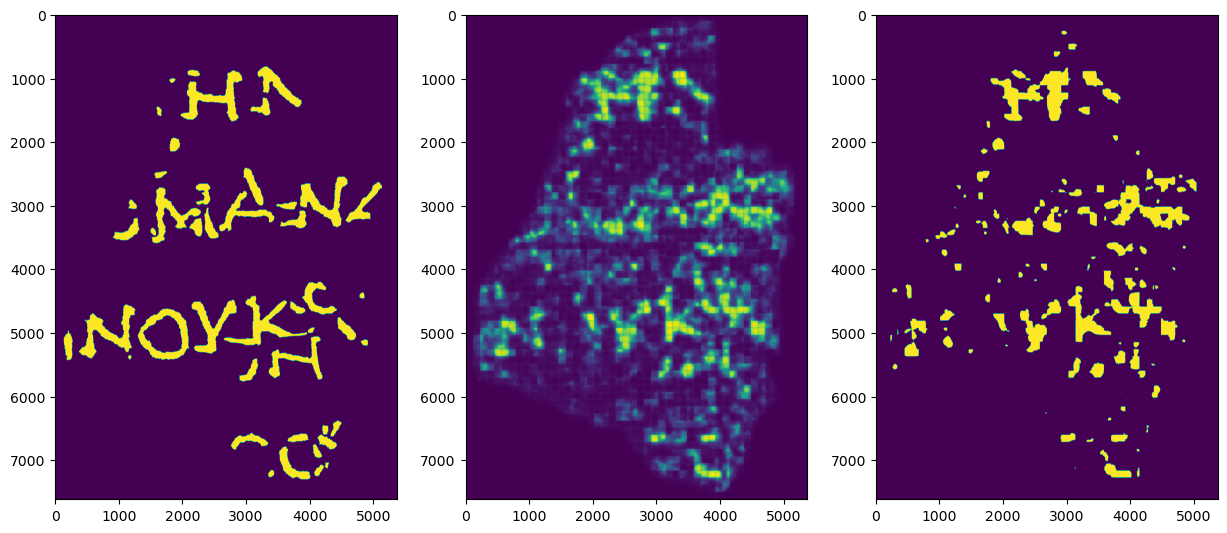

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([25111244.,  4580117.,  2563724.,  1733698.,  1199583.,   867755.,
          654481.,   535085.,   441914.,   396182.,   361701.,   318458.,
          279248.,   286006.,   280653.,   266163.,   308034.,   432113.,
          269034.,    58423.]),
 array([5.79222797e-05, 4.74899895e-02, 9.49220566e-02, 1.42354124e-01,
        1.89786191e-01, 2.37218258e-01, 2.84650325e-01, 3.32082392e-01,
        3.79514460e-01, 4.26946527e-01, 4.74378594e-01, 5.21810661e-01,
        5.69242728e-01, 6.16674796e-01, 6.64106863e-01, 7.11538930e-01,
        7.58970997e-01, 8.06403064e-01, 8.53835131e-01, 9.01267199e-01,
        9.48699266e-01]),
 <BarContainer object of 20 artists>)

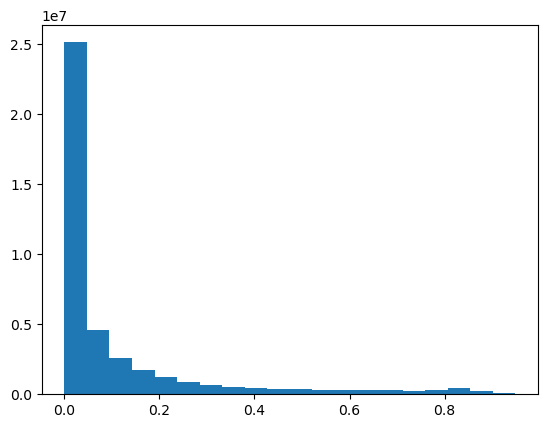

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000